# Projeto IATUR - Índice de Atividades Turísticas

---

A IATUR integra a PMS (Pesquisa Mensal de Serviços do IBGE) e é uma pesquisa de amostragem probabílística de divulgação mensal, que tem por objetivo mensurar o desempenho turístico dos estados através da construção de índices que avaliam os serviços de:

1.   Alojamento e alimentação
2.   Serviços culturais, desportivos, de recreação e lazer
3.   Locação de automóveis sem condutor
4.   Agências de viagens e operadoras turísticas
5.   Transportes turísticos


Dessa forma, a IATUR consiste de índices de volume e de receita da atividade turística que permitem o acompanhamento sistemático do desempenho turístico no país a nível de unidade da federação.

Os índices para volume e receita são:


1.   Índice de base fixa nominal
2.   Mês/Mesmo Mês do Ano Anterior
3.   Mês/Mês Imediatamente Anterior
4.   Acumulado em 12 meses
5.   Acumulado no ano


Demais informações e referências:

*   Dados desde janeiro de 2011
*   Ano base = 2022
*   [Conceitos e Métodos da IATUR](https://metadados.ibge.gov.br/consulta/estatisticos/operacoes-estatisticas/SC)
*   [Notas Metodológicas da IATUR](https://ftp.ibge.gov.br/Comercio_e_Servicos/Pesquisa_Mensal_de_Servicos/Notas_Metodologicas/pms_notas_metodologicas_iatur.pdf)
*   [Metodologia de extração por meio da API do SIDRA](https://dkko.me/posts/coletando-ibge-sidra-populacao-municipios/)


# Preparando Ambiente

In [1]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd

from google.colab import drive
import os
from io import StringIO
import requests

from pathlib import Path

!pip install sidrapy
import sidrapy

In [ ]:
# Ligando Collab ao Meu Drive
drive.mount('/content/drive')

In [ ]:
# Alterando diretório de trabalho
os.chdir('/content/drive/MyDrive/Colab Notebooks/Projeto IATUR')

%pwd

# Criando Funções

In [ ]:
# Obter os períodos disponíveis de uma tabela
def get_periodos(agregado: str):
    url = f"https://servicodados.ibge.gov.br/api/v3/agregados/{agregado}/periodos"
    response = requests.get(url)
    return response.json()

In [ ]:
# Baixar tabelas do SIDRA e salvar no formato CSV no diretório
def download_table(
    sidra_tabela: str,
    territorial_level: str,
    ibge_territorial_code: str,
    variable: str = "allxp",
    classifications: dict = None,
    data_dir: Path = Path("data"),
) -> list[Path]:
    """Download a SIDRA table in CSV format on temp_dir()

    Args:
        sidra_tabela (str): SIDRA table code
        territorial_level (str): territorial level code
        ibge_territorial_code (str): IBGE territorial code
        variable (str, optional): variable code. Defaults to None.
        classifications (dict, optional): classifications and categories codes.
            Defaults to None.

    Returns:
        list[Path]: list of downloaded files
    """
    filepaths = []
    periodos = get_periodos(sidra_tabela)
    classificacoes = get_metadata(sidra_tabela)
    for periodo in periodos:
        filename = f"{periodo['id']}.csv"
        dest_filepath = data_dir / filename
        dest_filepath.parent.mkdir(exist_ok=True, parents=True)
        if dest_filepath.exists():
            print("File already exists:", dest_filepath)
            continue
        print("Downloading", filename)
        df = sidrapy.get_table(
            table_code=sidra_tabela,  # Tabela SIDRA
            territorial_level=territorial_level,  # Nível de Municípios
            ibge_territorial_code=ibge_territorial_code,  # Territórios
            period=periodo["id"],  # Período
            variable=variable,  # Variáveis
            classifications=classifications,
        )
        df.to_csv(dest_filepath, index=False, encoding="utf-8")
        filepaths.append(dest_filepath)
    return filepaths

In [ ]:
# Ler arquivos
def read_file(filepath: Path, **read_csv_args) -> pd.DataFrame:
    print("Reading file", filepath)
    data = pd.read_csv(filepath, skiprows=1, na_values=["...", "-"], **read_csv_args)
    return data

In [ ]:
# Refinar dados
def refine(df: pd.DataFrame) -> pd.DataFrame:
    df = (
        df.dropna(subset="Valor")
        .rename(
            columns={
                "Valor": "valor_indice",
                "Unidade da Federação (Código)": "id_uf",
                "Unidade da Federação": "uf",
                "Mês (Código)": "id_mes",
                "Mês": "mes",
                "Variável (Código)": "id_variavel",
                "Variável": "variavel",
                "Tipos de índice (Código)": "id_tipo_indice",
                "Tipos de índice": "tipo_indice",
            }
        )
        .assign(pessoas=lambda x: x["valor_indice"].astype(float))
    )
    df[["pesquisa", "tipo_variavel"]] = df["variavel"].str.split("PMS - ", expand=True, n=1)
    df['tipo_variavel'] = df['tipo_variavel'].fillna(df['pesquisa'])
    df = df.drop(columns=["variavel","pesquisa"])
    df = df[["mes", "id_uf", "uf", "tipo_indice", "tipo_variavel", "valor_indice"]]
    return df

# Extração dos Dados

In [ ]:
# Criando diretório para salvar os arquivos
data_dir = Path("data")
data_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# Lista pra colocar os caminhos dos arquivos baixados
files = []

In [ ]:
# Baixando Tabelas
sidra_tabela = "8694" # Tabela da IATUR na PMS
territorial_level = "3" # UF
ibge_territorial_code = "all" # Todos as UF disponíveis

files_census = download_table(
    sidra_tabela=sidra_tabela,
    territorial_level=territorial_level,
    ibge_territorial_code=ibge_territorial_code,
    variable="allxp", # Todas as variáveis disponíveis
    classifications={"11046": "all"}, # Todos os indíces disponíveis (Volume: 56728 e Receita: 56727)
    data_dir=data_dir,
)
files.extend(files_census)

# A requisição costuma dar pau depois de muitas tabelas baixadas, mas é só rodar novamente.
# Ao fazer isso a lista files será sobreposta pelas novas requisições, contudo, abaixo temos a correção para isso.


File already exists: data/201101.csv
File already exists: data/201102.csv
File already exists: data/201103.csv
File already exists: data/201104.csv
File already exists: data/201105.csv
File already exists: data/201106.csv
File already exists: data/201107.csv
File already exists: data/201108.csv
File already exists: data/201109.csv
File already exists: data/201110.csv
File already exists: data/201111.csv
File already exists: data/201112.csv
File already exists: data/201201.csv
File already exists: data/201202.csv
File already exists: data/201203.csv
File already exists: data/201204.csv
File already exists: data/201205.csv
File already exists: data/201206.csv
File already exists: data/201207.csv
File already exists: data/201208.csv
File already exists: data/201209.csv
File already exists: data/201210.csv
File already exists: data/201211.csv
File already exists: data/201212.csv
File already exists: data/201301.csv
File already exists: data/201302.csv
File already exists: data/201303.csv
F

In [ ]:
# Obtendo arquivos existentes no diretório antes de realizar a união e adicionando todos eles na lista
if os.path.exists(data_dir):
    files = [os.path.join(data_dir, f)
    for f in os.listdir(data_dir)
    if f.endswith(".csv")]
else:
    files = []

print(files)

In [ ]:
# Visualizando tabela individual de teste
teste = read_file("data/202409.csv")
teste.head()

Reading file data/202409.csv


,Nível Territorial (Código),Nível Territorial,Unidade de Medida (Código),Unidade de Medida,Valor,Unidade da Federação (Código),Unidade da Federação,Mês (Código),Mês,Variável (Código),Variável,Tipos de índice (Código),Tipos de índice
0,3,Unidade da Federação,30,Número-índice,108.21736,13,Amazonas,202409,setembro 2024,7167,PMS - Número-índice (2022=100),56727,Índice de receita nominal das atividades turís...
1,3,Unidade da Federação,30,Número-índice,98.96589,13,Amazonas,202409,setembro 2024,7167,PMS - Número-índice (2022=100),56728,Índice de volume das atividades turísticas
2,3,Unidade da Federação,30,Número-índice,106.73702,13,Amazonas,202409,setembro 2024,7168,PMS - Número-índice com ajuste sazonal (2022=100),56727,Índice de receita nominal das atividades turís...
3,3,Unidade da Federação,30,Número-índice,94.99997,13,Amazonas,202409,setembro 2024,7168,PMS - Número-índice com ajuste sazonal (2022=100),56728,Índice de volume das atividades turísticas
4,3,Unidade da Federação,2,%,-2.90000,13,Amazonas,202409,setembro 2024,11623,"PMS - Variação mês/mês imediatamente anterior,...",56727,Índice de receita nominal das atividades turís...


In [ ]:
# Visualizando nomes das colunas
print(teste.columns)

Index(['Nível Territorial (Código)', 'Nível Territorial',
       'Unidade de Medida (Código)', 'Unidade de Medida', 'Valor',
       'Unidade da Federação (Código)', 'Unidade da Federação', 'Mês (Código)',
       'Mês', 'Variável (Código)', 'Variável', 'Tipos de índice (Código)',
       'Tipos de índice'],
      dtype='object')


In [ ]:
# Visualizando nomes dos Índices
teste["Variável"].unique()

array(['PMS - Número-índice (2022=100)',
       'PMS - Número-índice com ajuste sazonal (2022=100)',
       'PMS - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1)',
       'PMS - Variação mês/mesmo mês do ano anterior (M/M-12)',
       'PMS - Variação acumulada no ano (em relação ao mesmo período do ano anterior)',
       'PMS - Variação acumulada em 12 meses (em relação ao período anterior de 12 meses)'],
      dtype=object)

In [ ]:
# Visualizando tipos dos Índices
teste["Tipos de índice"].unique()

array(['Índice de receita nominal das atividades turísticas',
       'Índice de volume das atividades turísticas'], dtype=object)

In [ ]:
# Unindo Arquivos
df = refine(
    pd.concat(
        (
            read_file(file, usecols=("Valor",
                                     "Unidade da Federação (Código)","Unidade da Federação",
                                     "Mês (Código)", "Mês",
                                     'Variável (Código)', "Variável",
                                     'Tipos de índice (Código)', "Tipos de índice"))
            for file in files
        ),
        ignore_index=True,
    )
)

Reading file data/201101.csv
Reading file data/201102.csv
Reading file data/201103.csv
Reading file data/201104.csv
Reading file data/201105.csv
Reading file data/201106.csv
Reading file data/201107.csv
Reading file data/201108.csv
Reading file data/201109.csv
Reading file data/201110.csv
Reading file data/201111.csv
Reading file data/201112.csv
Reading file data/201201.csv
Reading file data/201202.csv
Reading file data/201203.csv
Reading file data/201204.csv
Reading file data/201205.csv
Reading file data/201206.csv
Reading file data/201207.csv
Reading file data/201208.csv
Reading file data/201209.csv
Reading file data/201210.csv
Reading file data/201211.csv
Reading file data/201212.csv
Reading file data/201301.csv
Reading file data/201302.csv
Reading file data/201303.csv
Reading file data/201304.csv
Reading file data/201305.csv
Reading file data/201306.csv
Reading file data/201307.csv
Reading file data/201308.csv
Reading file data/201309.csv
Reading file data/201310.csv
Reading file d

In [ ]:
# Informações sobre o df
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 32028 entries, 0 to 33659
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mes            32028 non-null  object 
 1   id_uf          32028 non-null  int64  
 2   uf             32028 non-null  object 
 3   tipo_indice    32028 non-null  object 
 4   tipo_variavel  32028 non-null  object 
 5   valor_indice   32028 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 1.7+ MB
None


In [ ]:
df.head()

,mes,id_uf,uf,tipo_indice,tipo_variavel,valor_indice
0,janeiro 2011,13,Amazonas,Índice de receita nominal das atividades turís...,Número-índice (2022=100),58.74847
1,janeiro 2011,13,Amazonas,Índice de volume das atividades turísticas,Número-índice (2022=100),112.14222
2,janeiro 2011,13,Amazonas,Índice de receita nominal das atividades turís...,Número-índice com ajuste sazonal (2022=100),59.61469
3,janeiro 2011,13,Amazonas,Índice de volume das atividades turísticas,Número-índice com ajuste sazonal (2022=100),119.36073
12,janeiro 2011,15,Pará,Índice de receita nominal das atividades turís...,Número-índice (2022=100),37.68129


In [ ]:
df["tipo_indice"].value_counts()

,count
tipo_indice,
Índice de receita nominal das atividades turísticas,16014
Índice de volume das atividades turísticas,16014


In [ ]:
df["tipo_variavel"].value_counts()

,count
tipo_variavel,
Número-índice (2022=100),5610
Número-índice com ajuste sazonal (2022=100),5610
"Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1)",5576
Variação mês/mesmo mês do ano anterior (M/M-12),5202
Variação acumulada no ano (em relação ao mesmo período do ano anterior),5202
Variação acumulada em 12 meses (em relação ao período anterior de 12 meses),4828


In [ ]:
df['mes'].unique()

array(['janeiro 2011', 'fevereiro 2011', 'março 2011', 'abril 2011',
       'maio 2011', 'junho 2011', 'julho 2011', 'agosto 2011',
       'setembro 2011', 'outubro 2011', 'novembro 2011', 'dezembro 2011',
       'janeiro 2012', 'fevereiro 2012', 'março 2012', 'abril 2012',
       'maio 2012', 'junho 2012', 'julho 2012', 'agosto 2012',
       'setembro 2012', 'outubro 2012', 'novembro 2012', 'dezembro 2012',
       'janeiro 2013', 'fevereiro 2013', 'março 2013', 'abril 2013',
       'maio 2013', 'junho 2013', 'julho 2013', 'agosto 2013',
       'setembro 2013', 'outubro 2013', 'novembro 2013', 'dezembro 2013',
       'janeiro 2014', 'fevereiro 2014', 'março 2014', 'abril 2014',
       'maio 2014', 'junho 2014', 'julho 2014', 'agosto 2014',
       'setembro 2014', 'outubro 2014', 'novembro 2014', 'dezembro 2014',
       'janeiro 2015', 'fevereiro 2015', 'março 2015', 'abril 2015',
       'maio 2015', 'junho 2015', 'julho 2015', 'agosto 2015',
       'setembro 2015', 'outubro 2015', 'nov

In [ ]:
df['uf'].unique()

array(['Amazonas', 'Pará', 'Ceará', 'Rio Grande do Norte', 'Pernambuco',
       'Alagoas', 'Bahia', 'Minas Gerais', 'Espírito Santo',
       'Rio de Janeiro', 'São Paulo', 'Paraná', 'Santa Catarina',
       'Rio Grande do Sul', 'Mato Grosso', 'Goiás', 'Distrito Federal'],
      dtype=object)

In [ ]:
# Salvando em CSV único
df.to_csv("IATUR (2011 a 2024).csv", index=False, encoding="utf-8")

# Pré Processamento

In [ ]:
# Criando colunas de mês e ano separadas
df[["mes", "ano"]] = df["mes"].str.split(" ", expand=True)

In [ ]:
df.head()

,mes,id_uf,uf,tipo_indice,tipo_variavel,valor_indice,ano
0,janeiro,13,Amazonas,Índice de receita nominal das atividades turís...,Número-índice (2022=100),58.74847,2011
1,janeiro,13,Amazonas,Índice de volume das atividades turísticas,Número-índice (2022=100),112.14222,2011
2,janeiro,13,Amazonas,Índice de receita nominal das atividades turís...,Número-índice com ajuste sazonal (2022=100),59.61469,2011
3,janeiro,13,Amazonas,Índice de volume das atividades turísticas,Número-índice com ajuste sazonal (2022=100),119.36073,2011
12,janeiro,15,Pará,Índice de receita nominal das atividades turís...,Número-índice (2022=100),37.68129,2011


In [ ]:
# Criando coluna de Região
dict_regiao = {'Norte': ['Amazonas', 'Pará'],
               'Nordeste': ['Ceará', 'Rio Grande do Norte', 'Pernambuco', 'Alagoas', 'Bahia'],
               'Sul': ['Paraná', 'Santa Catarina', 'Rio Grande do Sul'],
               'Sudeste': ['Minas Gerais', 'Espírito Santo', 'Rio de Janeiro', 'São Paulo'],
               'Centro Oeste': ['Mato Grosso', 'Goiás', 'Distrito Federal']
               }

# Invertendo dicionario para mapear
regiao_por_uf = {uf: regiao for regiao, ufs in dict_regiao.items() for uf in ufs}

# Criando coluna
df['regiao'] = df['uf'].map(regiao_por_uf)

In [ ]:
# Obtendo representatividade das regiões na pesquisa
df['regiao'].value_counts(normalize=True)

,proportion
regiao,
Nordeste,0.294118
Sudeste,0.235294
Sul,0.176471
Centro Oeste,0.176471
Norte,0.117647


In [ ]:
# Reordenando Colunas
nova_ordem_colunas = ['ano', 'mes', 'id_uf', 'uf', 'regiao', 'tipo_indice', 'tipo_variavel', 'valor_indice']

df = df[nova_ordem_colunas]

# Análise Geral

### Abrangência de Pesquisa

In [ ]:
# Lendo arquivo .shp baixado no site do IBGE
brasil_uf = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Projeto IATUR/shapefile_brasil/BR_UF_2022.shp')

In [ ]:
brasil_uf.head()

In [ ]:
brasil_uf = brasil_uf.rename(columns={'CD_UF': 'id_uf',
                                      'NM_UF': 'uf',
                                      'NM_REGIAO': 'regiao'
                                      })

In [ ]:
# Unindo malha ao df
mapa = brasil_uf.merge(df[['uf', 'regiao']].drop_duplicates(), on='uf', how='left')

In [ ]:
print(mapa.columns)

Index(['id_uf', 'uf', 'SIGLA_UF', 'regiao_x', 'AREA_KM2', 'geometry',
       'regiao_y'],
      dtype='object')


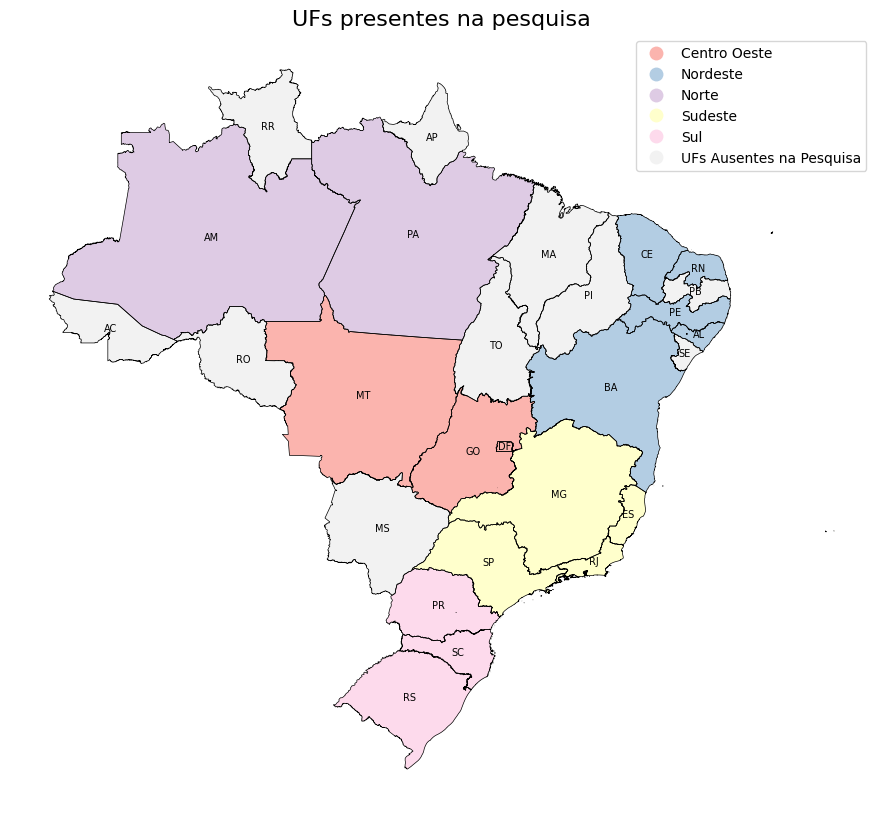

In [ ]:
# Plotando

# Criando nova categoria para UF's ausentes
mapa['regiao_y'] = mapa['regiao_y'].fillna('UFs Ausentes na Pesquisa')


fig, ax = plt.subplots(figsize=(12, 10))

mapa.plot(column='regiao_y', cmap='Pastel1', legend=True, ax=ax)
mapa.boundary.plot(ax=ax, color='black', linewidth=0.5)

for idx, row in mapa.iterrows():
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, row['SIGLA_UF'], ha='center', va='center', fontsize=7)

ax.set_title('UFs presentes na pesquisa', fontsize=16)
ax.set_axis_off()

plt.show()

# Análise de caso: COSUD


---


O Consórcio de Integração Sul e Sudeste (Cosud) foi criado em 2019 com o objetivo de fortalecer a cooperação entre os Governos de ambas as regiões e, assim, impulsionar ações socioeconômicas nas áreas de meio ambiente, segurança pública, assistência social, cultura, infraestrutura, saúde, esporte, turismo, mobilidade, educação, desenvolvimento econômico, inovação, tecnologia e eficiência na gestão.

Seus sete Estados (São Paulo, Rio de Janeiro, Espírito Santo, Minas Gerais, Rio Grande do Sul, Paraná e Santa Catarina) acolhem mais de 114 milhões de habitantes, o que corresponde a 56,5% da população do país. Além disso, representam 70% do Produto Interno Bruto (PIB) nacional, segundo dados do Instituto Brasileiro de Geografia e Estatística (IBGE).

> [Referências](https://sefaz.es.gov.br/Not%C3%ADcia/governadores-do-sul-e-sudeste-assinam-carta-com-intencoes-comuns-entre-os-estados#:~:text=Sobre%20o%20Cosud&text=Seus%20sete%20Estados%20(S%C3%A3o%20Paulo,56%2C5%25%20da%20popula%C3%A7%C3%A3o.)



In [ ]:
# Filtrando estados do COSUD
cosud = pd.Series(["Sul", "Sudeste"])

df_cosud = df[df['regiao'].isin(cosud)]

In [ ]:
df_cosud.head()

,ano,mes,id_uf,uf,regiao,tipo_indice,tipo_variavel,valor_indice
84,2011,janeiro,31,Minas Gerais,Sudeste,Índice de receita nominal das atividades turís...,Número-índice (2022=100),44.12214
85,2011,janeiro,31,Minas Gerais,Sudeste,Índice de volume das atividades turísticas,Número-índice (2022=100),78.75757
86,2011,janeiro,31,Minas Gerais,Sudeste,Índice de receita nominal das atividades turís...,Número-índice com ajuste sazonal (2022=100),42.97915
87,2011,janeiro,31,Minas Gerais,Sudeste,Índice de volume das atividades turísticas,Número-índice com ajuste sazonal (2022=100),79.26826
96,2011,janeiro,32,Espírito Santo,Sudeste,Índice de receita nominal das atividades turís...,Número-índice (2022=100),56.69158


In [ ]:
df_cosud['tipo_variavel'].value_counts()

,count
tipo_variavel,
Número-índice (2022=100),2310
Número-índice com ajuste sazonal (2022=100),2310
"Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1)",2296
Variação mês/mesmo mês do ano anterior (M/M-12),2142
Variação acumulada no ano (em relação ao mesmo período do ano anterior),2142
Variação acumulada em 12 meses (em relação ao período anterior de 12 meses),1988


In [ ]:
df_cosud['tipo_indice'].unique()

array(['Índice de receita nominal das atividades turísticas',
       'Índice de volume das atividades turísticas'], dtype=object)

In [ ]:
# Preparando df_cosud para criar os gráficos

# Filtrando
variaveis_desejadas = [
    "Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1)",
    "Variação mês/mesmo mês do ano anterior (M/M-12)",
    "Variação acumulada no ano (em relação ao mesmo período do ano anterior)",
    "Variação acumulada em 12 meses (em relação ao período anterior de 12 meses)",
]

df_filtrado = df_cosud[df_cosud["tipo_variavel"].isin(variaveis_desejadas)]

# Alterando o nome do tipo da variável
mapeamento_tipo_indice = {
    "Índice de volume das atividades turísticas": "Volume",
    "Índice de receita nominal das atividades turísticas": "Receita Nominal",
}

df_filtrado = df_cosud[df_cosud["tipo_variavel"].isin(variaveis_desejadas)].copy()
df_filtrado["tipo_indice"] = df_filtrado["tipo_indice"].map(mapeamento_tipo_indice)

# Ordenamento cronológico dos meses
meses_ordem = [
    "janeiro",
    "fevereiro",
    "março",
    "abril",
    "maio",
    "junho",
    "julho",
    "agosto",
    "setembro",
    "outubro",
    "novembro",
    "dezembro",
]

df_filtrado["mes"] = pd.Categorical(df_filtrado["mes"], categories=meses_ordem, ordered=True)



In [ ]:
# Criando gráficos interativos para visualizar os indíces por tipo de índice, tipo de variável e UF
for variavel in variaveis_desejadas:
    fig = px.bar(
        df_filtrado[df_filtrado["tipo_variavel"] == variavel],
        x="ano",
        y="valor_indice",
        color="uf",
        barmode="group",
        animation_frame="mes",
        facet_col="tipo_indice",
        title=f"IATUR (2011 a 2024/09) - COSUD - {variavel}",
        labels = "valor_indice",
        template="plotly_dark"
    )

    # Removendo titulos dos eixos
    fig.update_xaxes(title_text="")
    fig.update_yaxes(title_text="")

    # Removendo legenda
    fig.update_layout(showlegend=True, legend_title_text=None)

    # Centralizando título
    fig.update_layout(title_x=0.5)

    # Alterar texto acima de cada gráfico
    for annotation in fig["layout"]["annotations"]:
        if annotation["text"].startswith("tipo_indice="):
            annotation["text"] = annotation["text"].replace(
                "tipo_indice=", ""
            )  # Remover "tipo_indice="


    fig.show()

#### Redigir texto comentando gráficos e comparação de períodos